# MegaMart customer clustering analysis
Marcos Saade

Gabriel Masri

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('retail_customer_data-1.csv')
df.head()

customer_id  monthly_transactions  avg_basket_size  total_spend  \
0   CUST_0001                   1.8              3.0       527.04   
1   CUST_0002                   5.4              4.5      1137.72   
2   CUST_0003                   2.9              4.4       670.28   
3   CUST_0004                  12.0             22.8      6359.35   
4   CUST_0005                   2.2             17.6      4058.48   

   avg_session_duration  email_open_rate  product_views_per_visit  \
0                  38.1             0.95                     17.3   
1                  20.0             0.00                     16.1   
2                  64.3             0.52                     36.9   
3                  37.9             0.17                     42.2   
4                  22.5             0.53                     18.4   

   return_rate  customer_tenure_months  recency_days  
0         0.00                      23            33  
1         0.41                       1             8  
2         0.11                      32            39  
3         0.00                      21             5  
4         0.15                      20            18

In [4]:
df.describe()

monthly_transactions  avg_basket_size  total_spend  \
count           3000.000000      3000.000000  3000.000000   
mean               6.011300         9.485133  2367.375387   
std                4.776564         7.961280  2248.271454   
min                0.200000         1.000000    50.000000   
25%                2.100000         3.300000   511.115000   
50%                5.000000         5.600000  1456.105000   
75%                8.800000        17.325000  3772.227500   
max               22.300000        31.600000  8746.290000   

       avg_session_duration  email_open_rate  product_views_per_visit  \
count           3000.000000      3000.000000              3000.000000   
mean              38.441533         0.443720                31.359467   
std               14.334159         0.427384                 9.964088   
min                3.400000         0.000000                 3.000000   
25%               27.000000         0.000000                24.900000   
50%               36.550000         0.340000                31.600000   
75%               49.400000         0.950000                37.800000   
max               87.300000         0.950000                62.400000   

       return_rate  customer_tenure_months  recency_days  
count  3000.000000             3000.000000   3000.000000  
mean      0.185890               17.912667     20.680667  
std       0.162283               11.242294     12.055419  
min       0.000000                1.000000      1.000000  
25%       0.040000                9.000000     11.000000  
50%       0.150000               18.000000     18.000000  
75%       0.290000               26.000000     29.250000  
max       0.500000               59.000000     67.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB


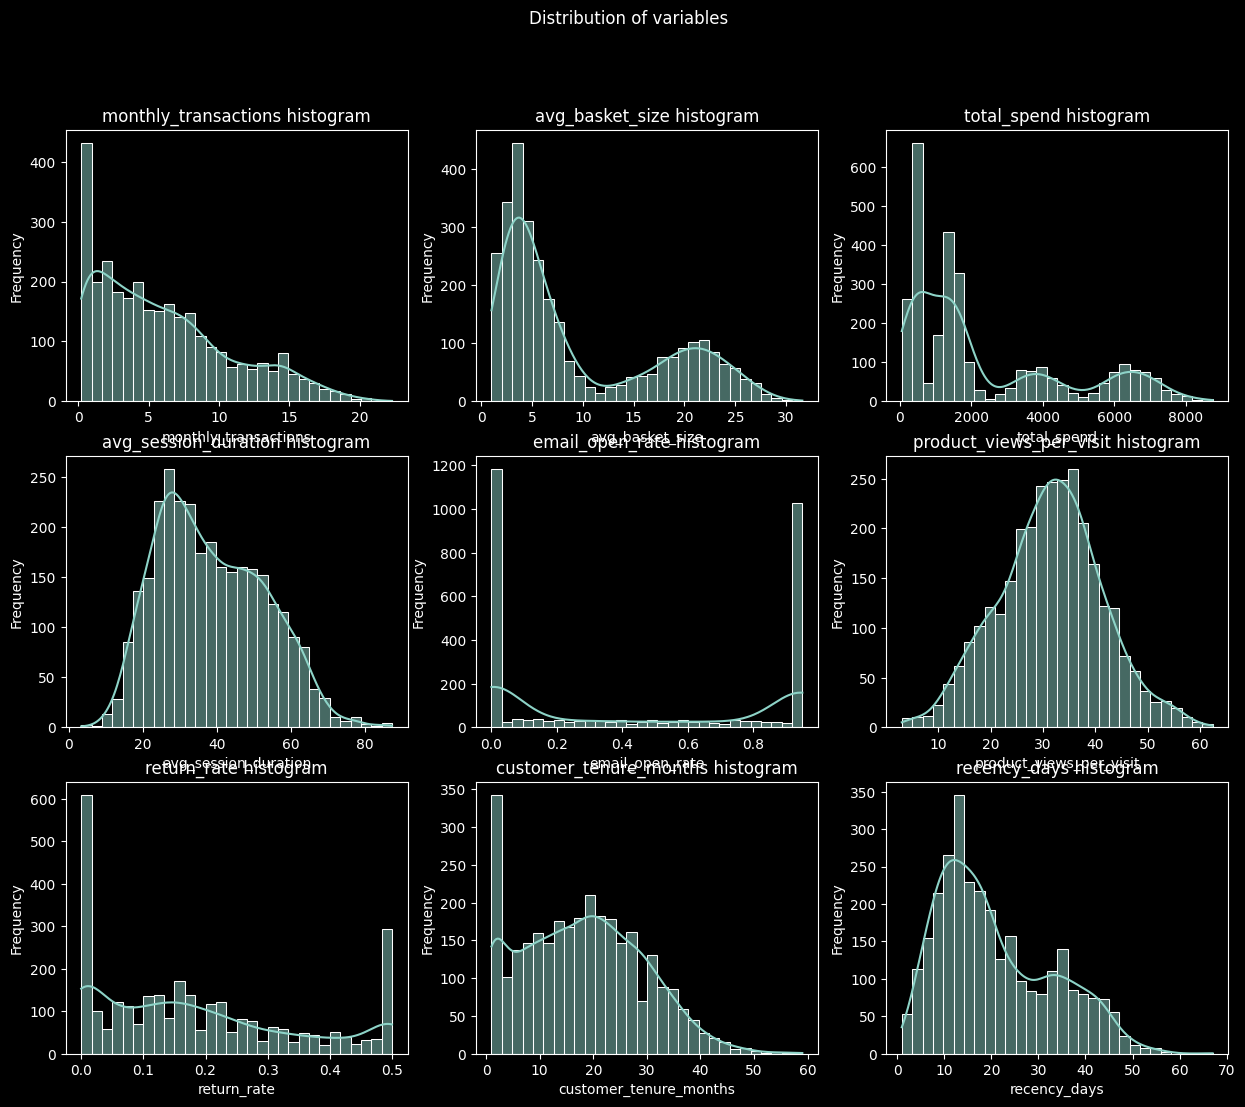

In [6]:
# Distribution plots for each variable

numeric = df.select_dtypes(include=['number'])

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribution of variables")

for i, column in enumerate(numeric.columns):
    if i==9:
        break

    row = i // 3
    col = i % 3

    sns.histplot(df[column], bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"{column} histogram")
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel("Frequency")

plt.show()

avg_basket_size and total_spend have a correlation of 0.9409720554882356
monthly_transactions and total_spend have a correlation of 0.764490426568803
monthly_transactions and avg_basket_size have a correlation of 0.6910774342152459
monthly_transactions and recency_days have a correlation of -0.6315835123497894
total_spend and recency_days have a correlation of -0.6116672571938544
0.39516228318500135


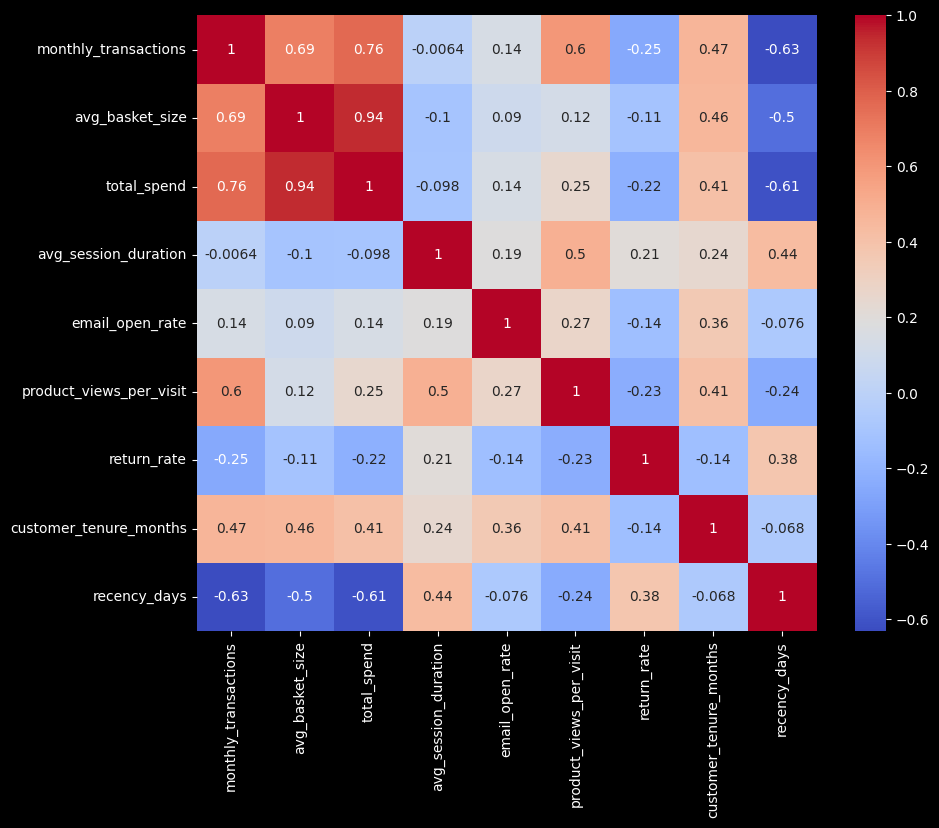

In [7]:
# Correlation matrix

plt.figure(figsize=(10, 8))
corr_matrix = numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        pairs.append((
            corr_matrix.columns[i],
            corr_matrix.columns[j],
            corr_matrix.iloc[i, j])
            )
        
pairs = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

for pair in pairs[0:5]:
    print(f"{pair[0]} and {pair[1]} have a correlation of {pair[2]}")


print(np.mean(abs(corr_matrix)))

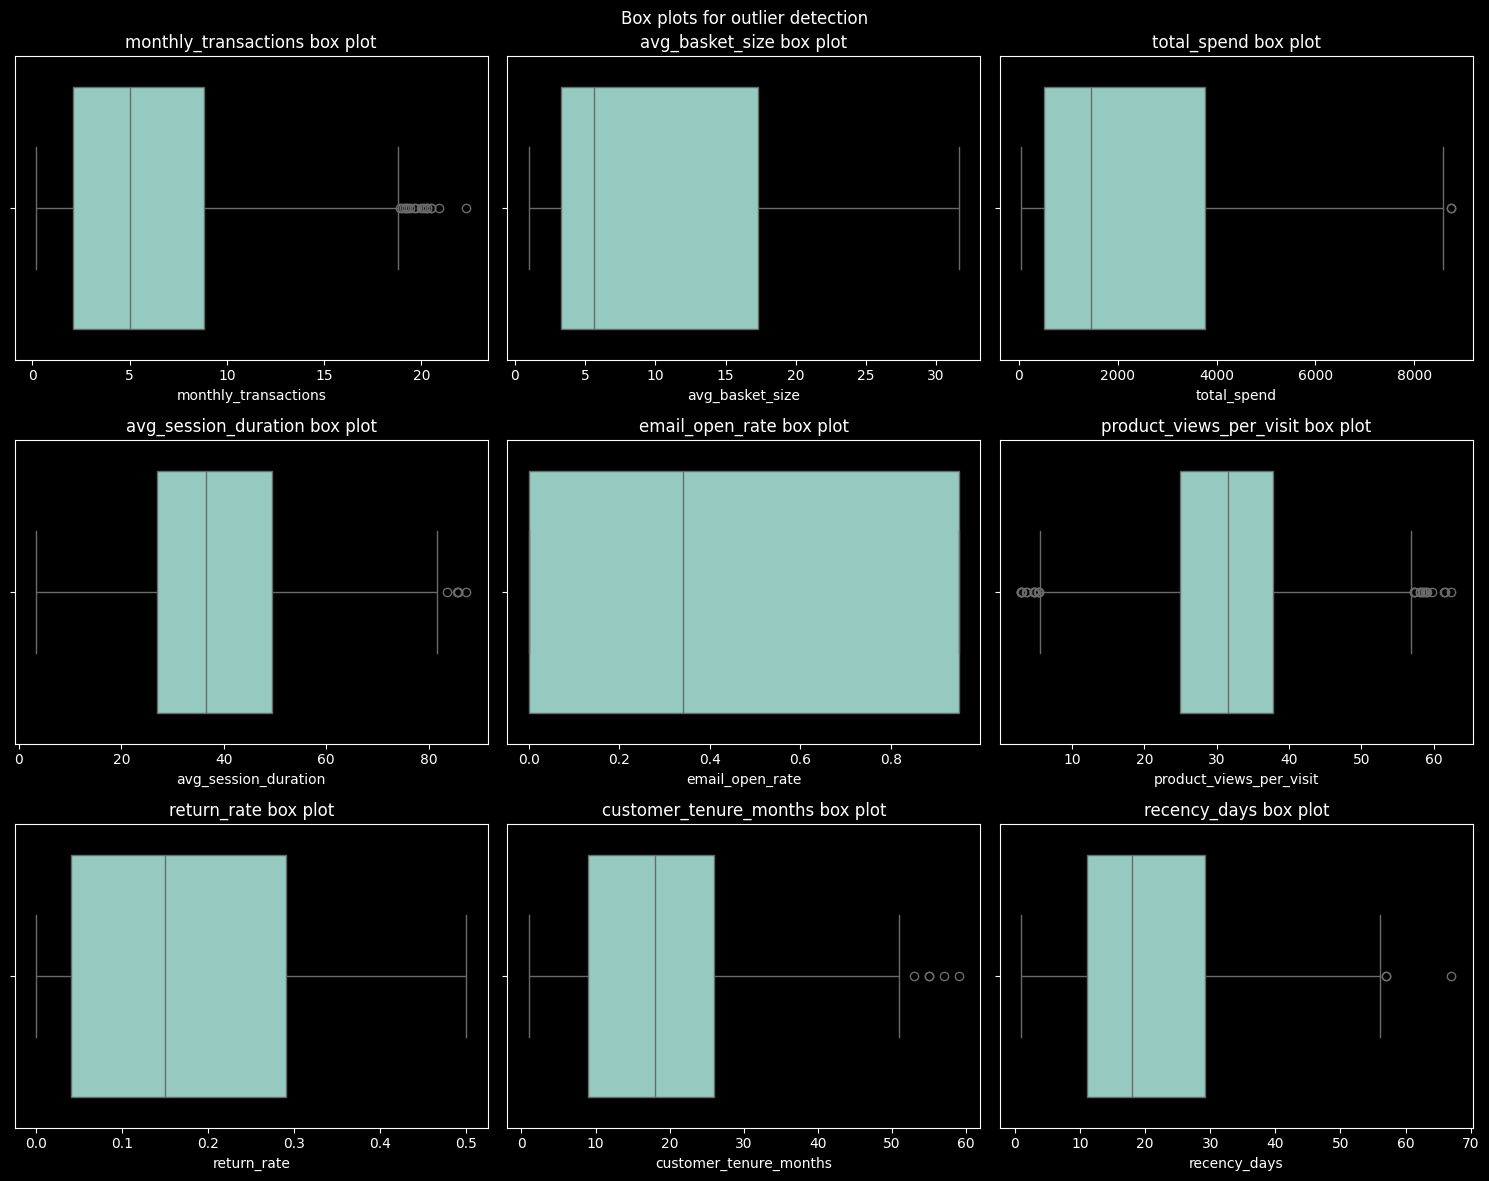

In [8]:
# Outlier detection with box plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Box plots for outlier detection")

for i, column in enumerate(numeric.columns):
    if i==9:
        break

    row = i // 3
    col = i % 3

    sns.boxplot(x=df[column], ax=axes[row, col])
    axes[row, col].set_title(f"{column} box plot")
    axes[row, col].set_xlabel(column)

plt.tight_layout()
plt.show()

From the box plots, we can see some skewness on some variables like avg_basket_size and total_spent.

Also, we can see some outliers in variables like monthly_transactions, product_views_per_visit, and others. These outliers can affect the clustering results, so we need to handle them appropriately before proceeding with the clustering analysis.

In [9]:
# Outlier quantification with Z-score

for col in numeric.columns:
    zs = zscore(numeric[col])
    outliers = numeric[np.abs(zs) > 3]

    if not outliers.empty:
        print(f"{col}: {len(outliers)} outliers detected")

zscores = zscore(numeric[numeric.columns[:9]])
zscores = np.abs(zscores) > 3
total_outliers = pd.DataFrame(zscores, columns=numeric.columns[:9])
print(f"Total outliers detected across all variables: {total_outliers.sum().sum()}")

monthly_transactions: 4 outliers detected
avg_session_duration: 6 outliers detected
product_views_per_visit: 3 outliers detected
customer_tenure_months: 5 outliers detected
recency_days: 3 outliers detected
Total outliers detected across all variables: 21


In [10]:
# Outlier removal using IQR
Q1 = numeric.quantile(0.25)
Q3 = numeric.quantile(0.75)

IQR = Q3 - Q1

lower = Q1 -1.5 * IQR
upper = Q3 + 1.5 * IQR

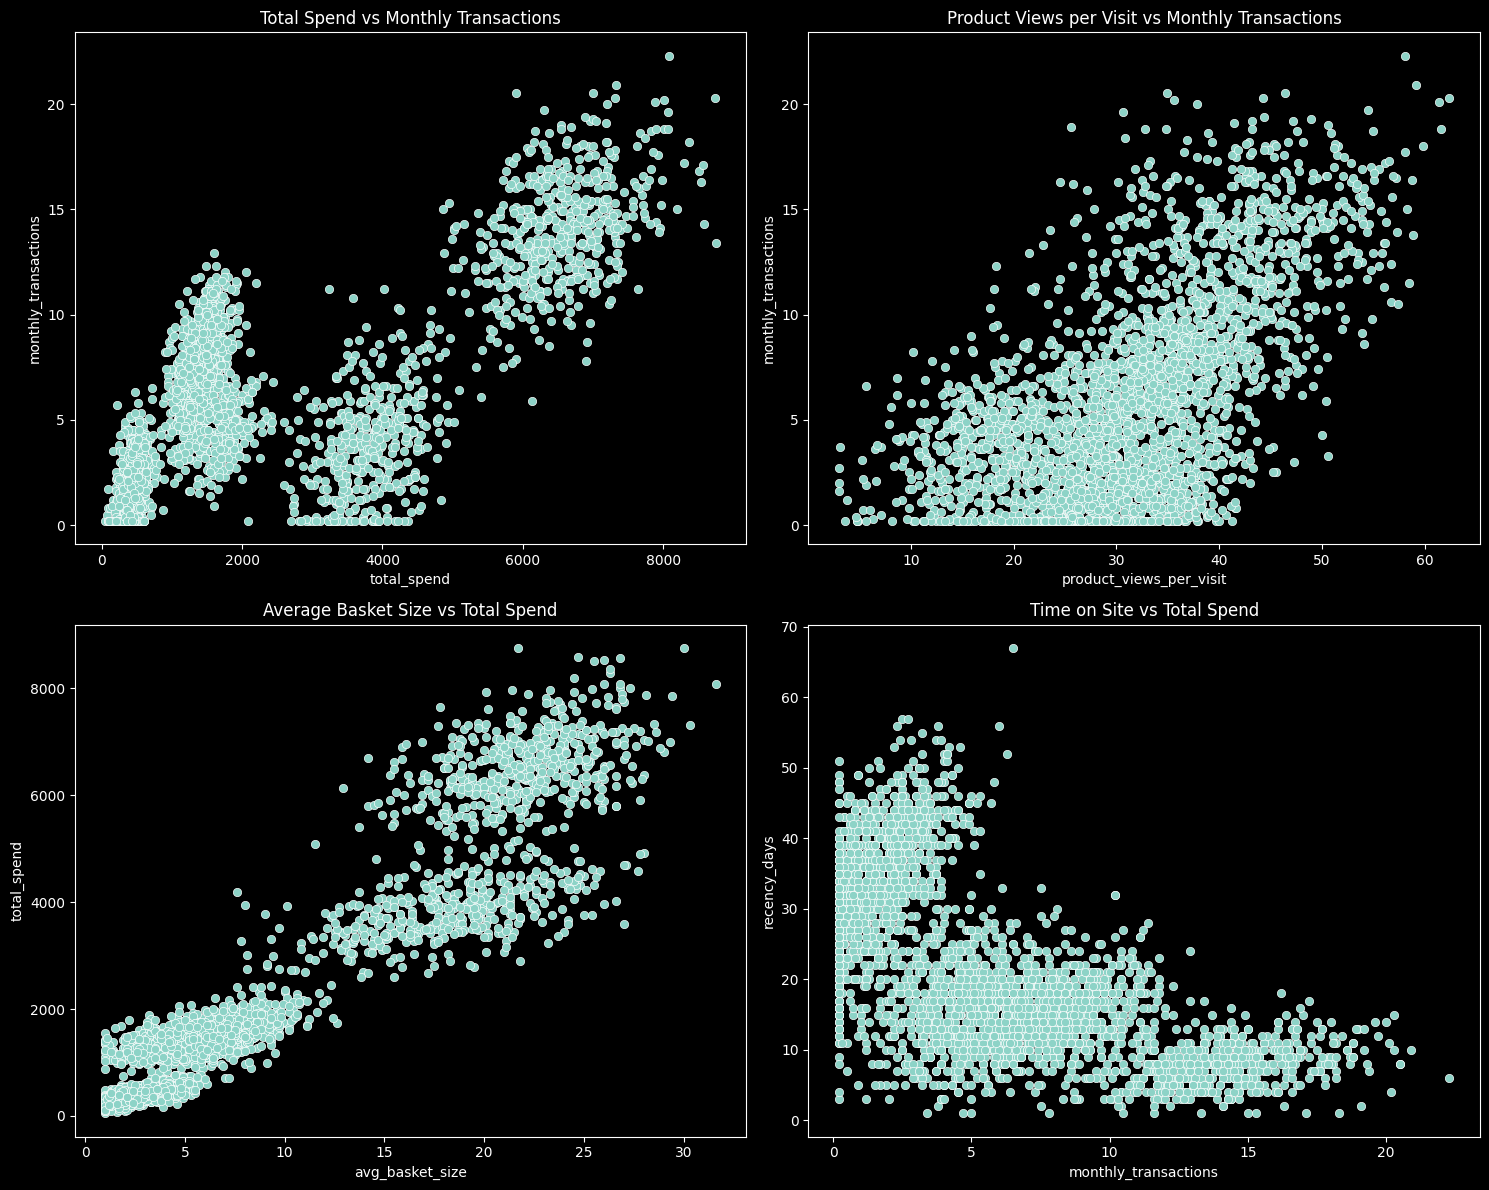

In [11]:
# Scatter plots

fig, axes = plt.subplots(2, 2, figsize=(15, 12))


sns.scatterplot(x=numeric['total_spend'], y=numeric['monthly_transactions'], ax=axes[0,0])
sns.scatterplot(x=numeric['avg_basket_size'], y=numeric['total_spend'], ax=axes[1,0])
sns.scatterplot(x=numeric['product_views_per_visit'], y=numeric['monthly_transactions'], ax=axes[0,1])
sns.scatterplot(x=numeric['monthly_transactions'], y=numeric['recency_days'], ax=axes[1,1])

axes[0,0].set_title('Total Spend vs Monthly Transactions')
axes[1,0].set_title('Average Basket Size vs Total Spend')
axes[0,1].set_title('Product Views per Visit vs Monthly Transactions')
axes[1,1].set_title('Time on Site vs Total Spend')
plt.tight_layout()

We can see that there are no missing values in any column. We have 3,000 customer records in areas such as monthly purchases, average basket size, average number of returned purchases, and so on. The variables are on different scales, so standardizing data is necessary.

We can osberve that some variablesduct views per visitnd average sesison duration ressemble a skewed normal distribution, while others like return rate and average basket size are multimodal.

We further note the strongest correlations:
avg_basket_size and total_spend have a correlation of 0.9409720554882356
monthly_transactions and total_spend have a correlation of 0.764490426568803

The average absolute correlation is 0.4, indicating strong predictive power between variables.

Outliers have been removed so they don't interfere with clustering results.

We can observe the relationship between key variables in the scatterplots.

## Clustering analysis: Hierarchical Clustering

We will perform Hierarchical clustering to discover natural groupings in the data. This is possible because we have relatively little data points.

In [12]:
# We need to scale the data for the clustering algorithms,
# else variables with larger ranges would dominate the distance calculations
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric)

# We convert to DataFrame again, as the last line returned a numpy array
X_scaled = pd.DataFrame(X_scaled)

X_scaled.describe().round(1)

0       1       2       3       4       5       6       7       8
count  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0  3000.0
mean      0.0    -0.0     0.0     0.0    -0.0     0.0    -0.0     0.0    -0.0
std       1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0
min      -1.2    -1.1    -1.0    -2.4    -1.0    -2.8    -1.1    -1.5    -1.6
25%      -0.8    -0.8    -0.8    -0.8    -1.0    -0.6    -0.9    -0.8    -0.8
50%      -0.2    -0.5    -0.4    -0.1    -0.2     0.0    -0.2     0.0    -0.2
75%       0.6     1.0     0.6     0.8     1.2     0.6     0.6     0.7     0.7
max       3.4     2.8     2.8     3.4     1.2     3.1     1.9     3.7     3.8

In the above DataFrame we can further observe that there are no significant outliers (max value is 3.8 STDs above 0, among 3000 data points), and that extremes tend to lie on the right

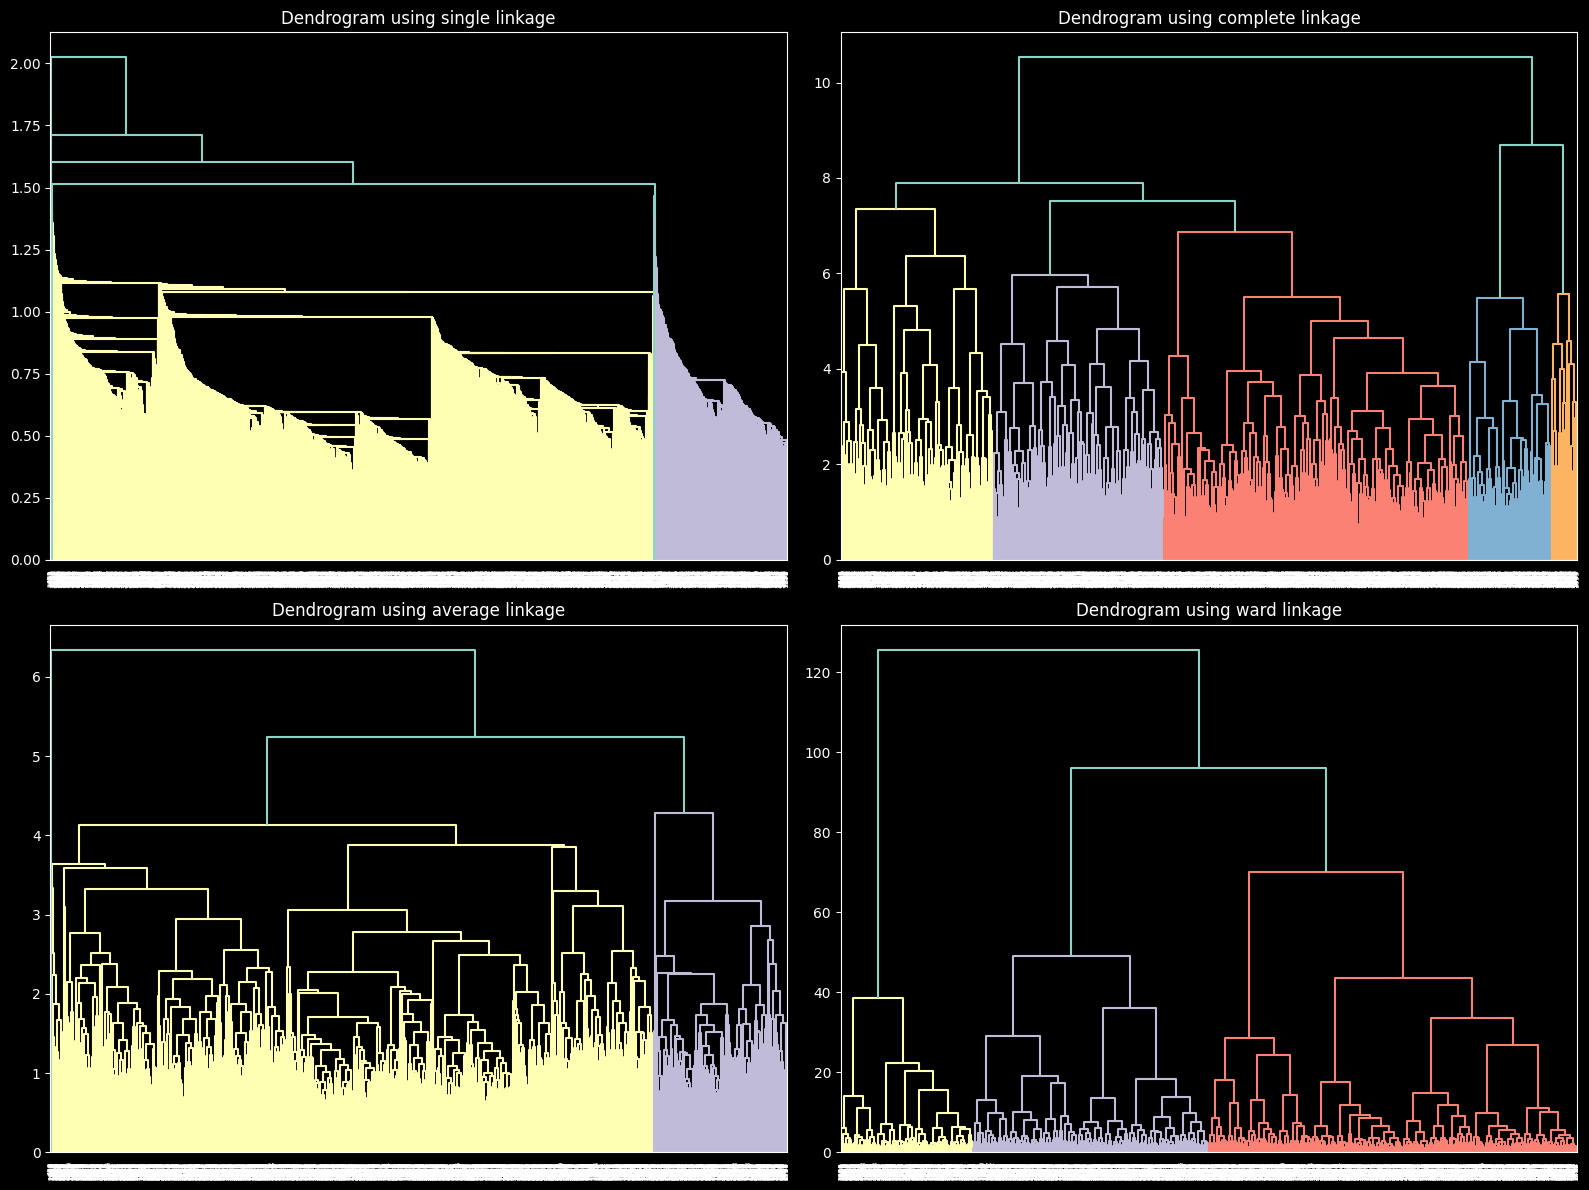

In [13]:
# We analyze different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(X_scaled, method=method)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, method in enumerate(linkage_matrices):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]
    ax.set_title(f"Dendrogram using {method} linkage")
    dendrogram(linkage_matrices[method], ax=ax)

plt.tight_layout()

We note that different methods suggest diffrent number of clusters. The linkage method can be tunned according to the project needs, but we recommend following the clustering recommended by the Ward method because it tries ot minize variance, which results in compact, centroid-like clusters, from which customer personas can be inferred. 

The dendrogram should be cut at a height of aproximately 80 to obtain 3 clusters. The height of the mergers indicates the distance between clusters. A higher height indicates more dissimilar clusters.

The chaining effect means that clusters are formed by adding one point at a time, which can lead to elongated, less compact clusters. This can be problematic for clustering analysis as it may not accurately represent the underlying structure of the data. The linkage methods that are more susceptible to the chaining effect are single linkage and complete linkage.

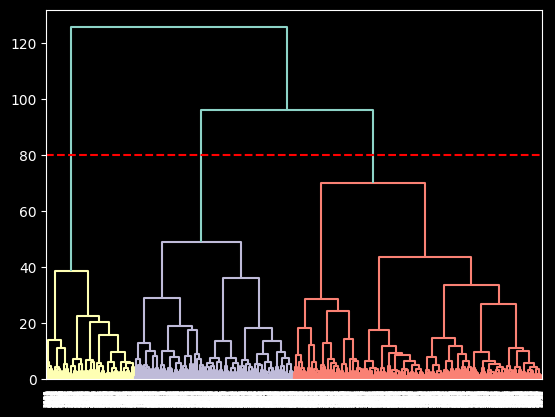

In [14]:
# A closer look at the Ward clusters
plt.figure()
dendrogram(linkage_matrices['ward'])
plt.axhline(y=80, color='r', linestyle='--')
plt.show()
plt.close()

In [15]:
# Determining the optimal number of clusters

ward = linkage(X_scaled, method='ward')

cluster_labels = {}

for k in [3, 4, 5, 6]:
    cluster_labels[k] = fcluster(ward, t=k, criterion='maxclust')

df['cluster_3'] = cluster_labels[3]
df['cluster_4'] = cluster_labels[4]
df['cluster_5'] = cluster_labels[5]
df['cluster_6'] = cluster_labels[6]

In [16]:
# Silhouette score
scores = {}

scores[3] = silhouette_score(X_scaled, df['cluster_3'])
scores[4] = silhouette_score(X_scaled, df['cluster_4'])
scores[5] = silhouette_score(X_scaled, df['cluster_5'])
scores[6] = silhouette_score(X_scaled, df['cluster_6'])

for k, score in scores.items():
    print(f"k={k}: Silhouette score = {score:.3f}")

k=3: Silhouette score = 0.295
k=4: Silhouette score = 0.316
k=5: Silhouette score = 0.300
k=6: Silhouette score = 0.248


We can see that the maixmum Silhouette score is 0.316 at 4 clusters

<Figure size 640x480 with 0 Axes>

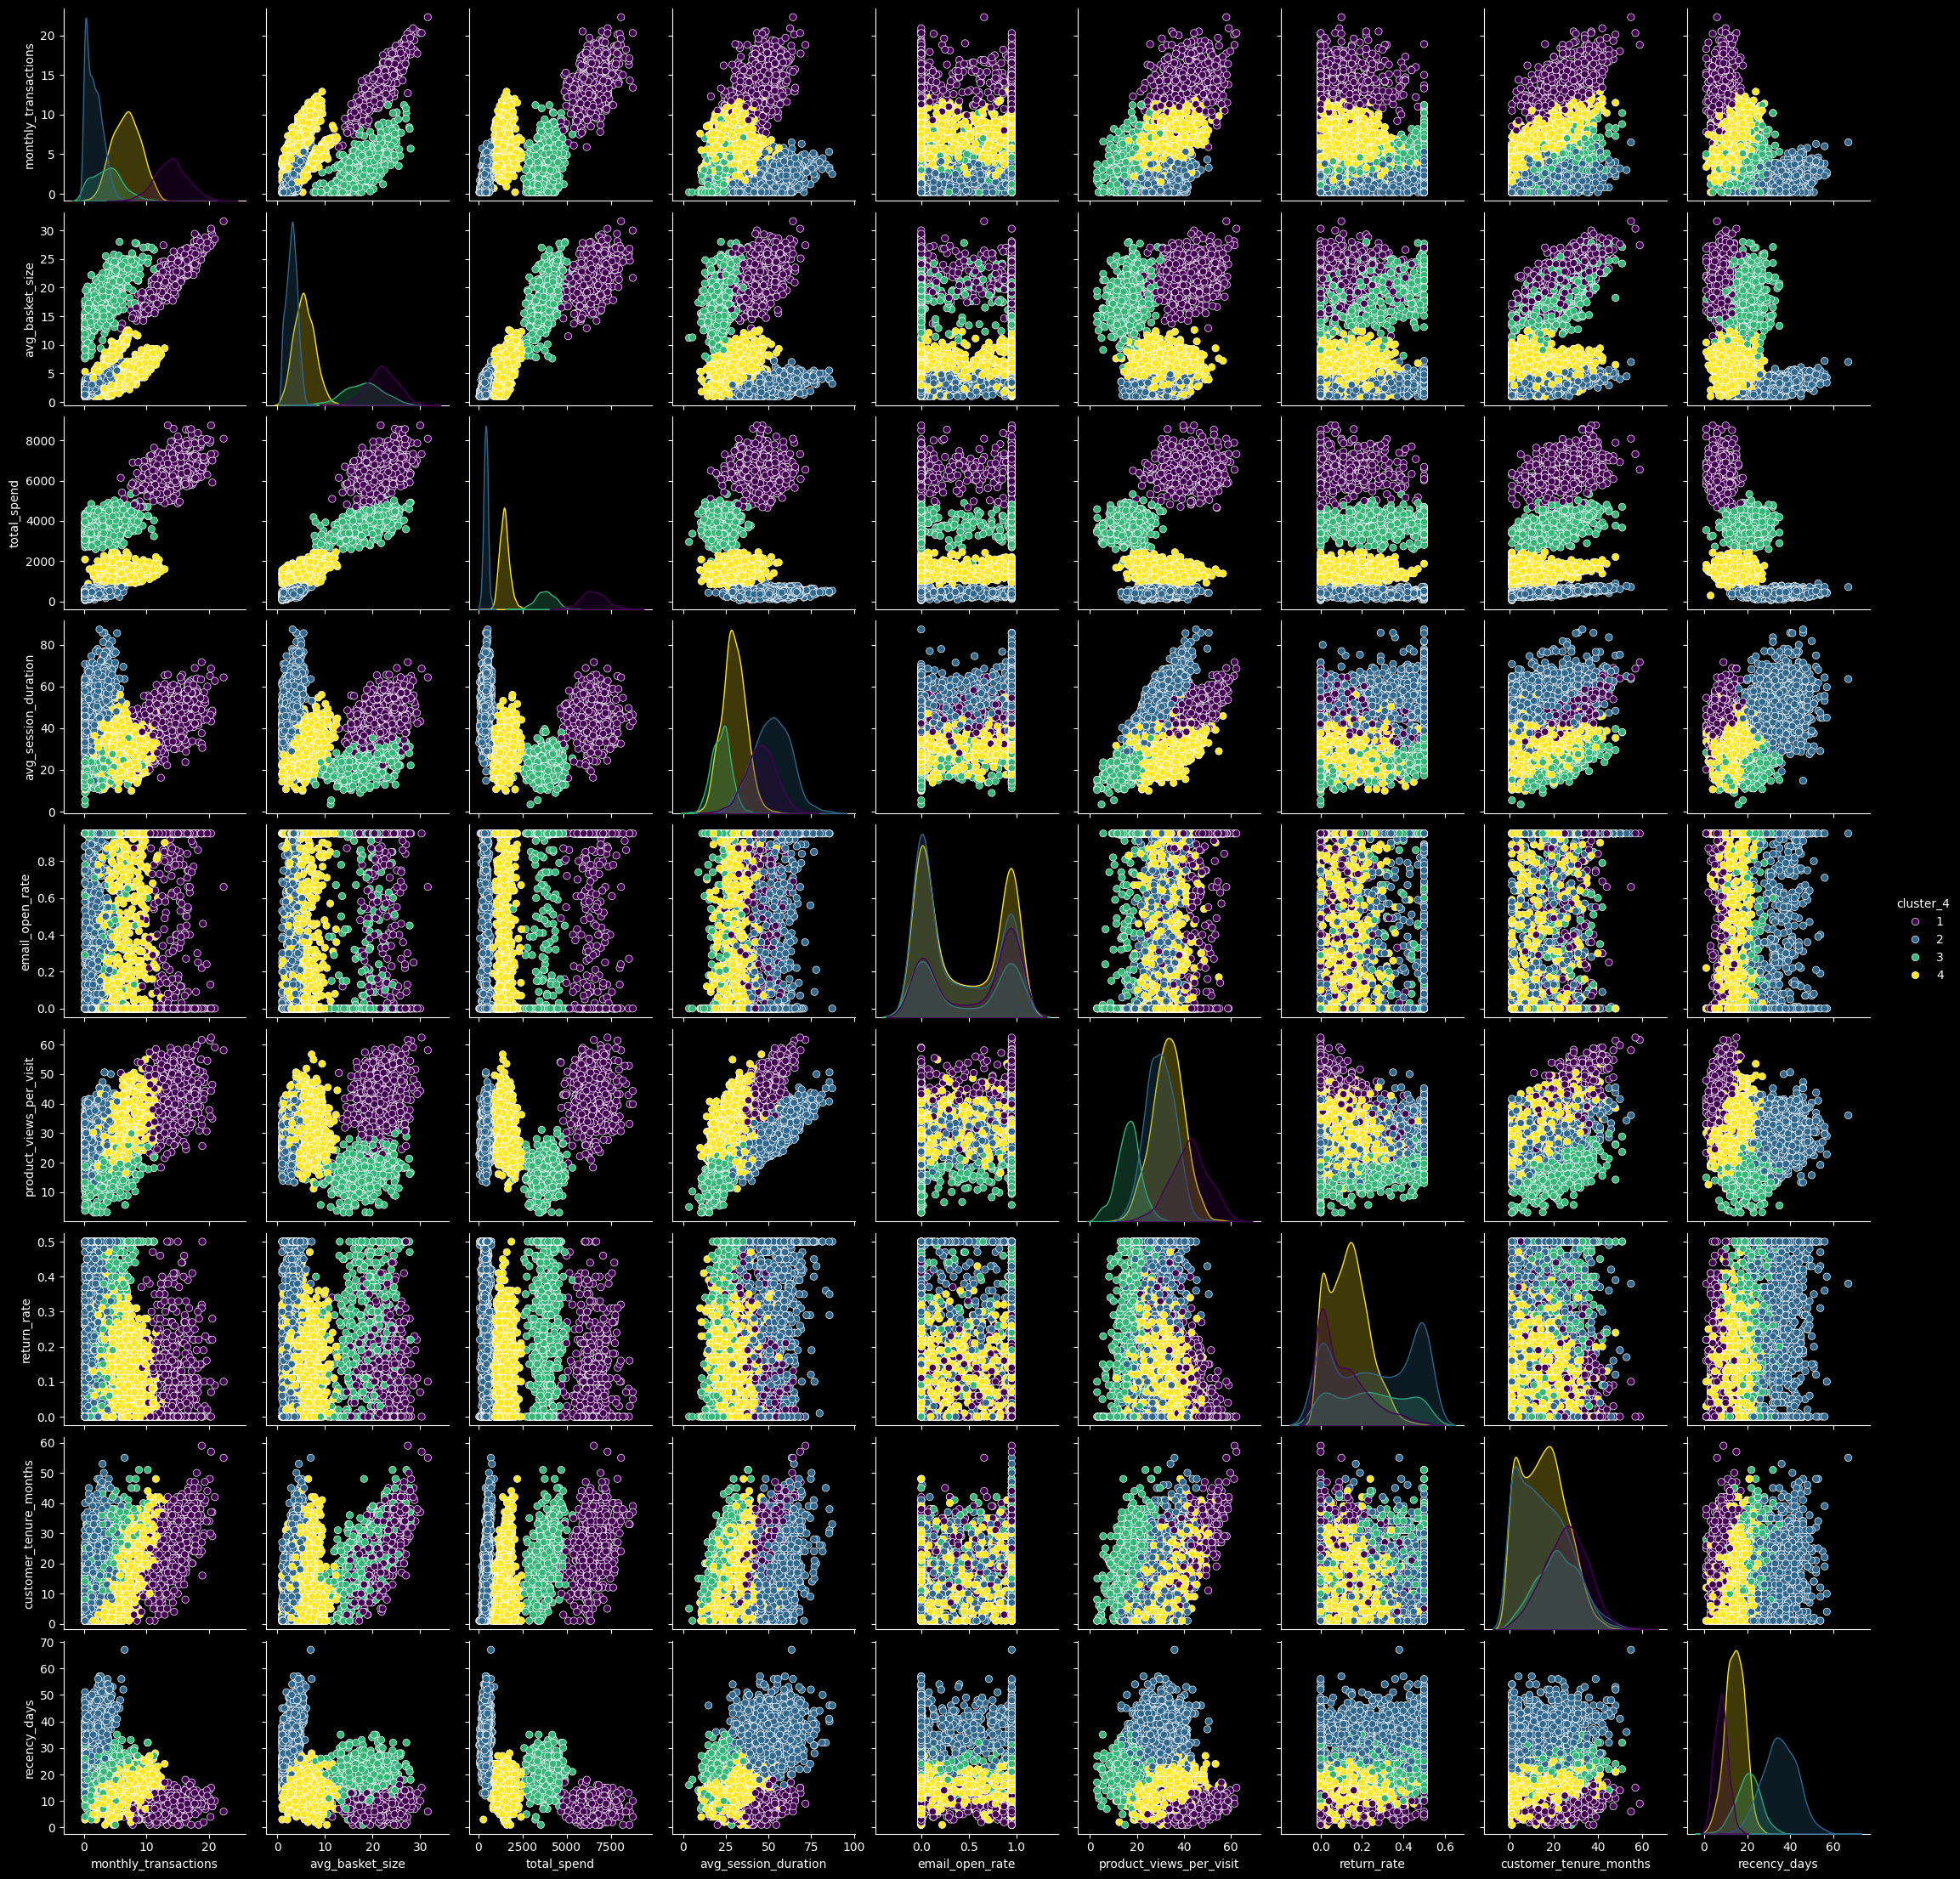

In [17]:
# Drop unnecessary cluster columns, keeping only cluster_4
df4 = df.drop(['cluster_3', 'cluster_5', 'cluster_6'], axis=1)

plt.figure()
sns.pairplot(df4, hue='cluster_4', palette='viridis')
plt.show()
plt.close()

## K-means clustering

2: 0.34455215855438126
3: 0.29739139902097755
4: 0.31731083817036076
5: 0.26957915200409066
6: 0.2617386465687415
7: 0.26869804016616367
8: 0.27935778574393233
9: 0.2723227137107343
10: 0.27334027138672273


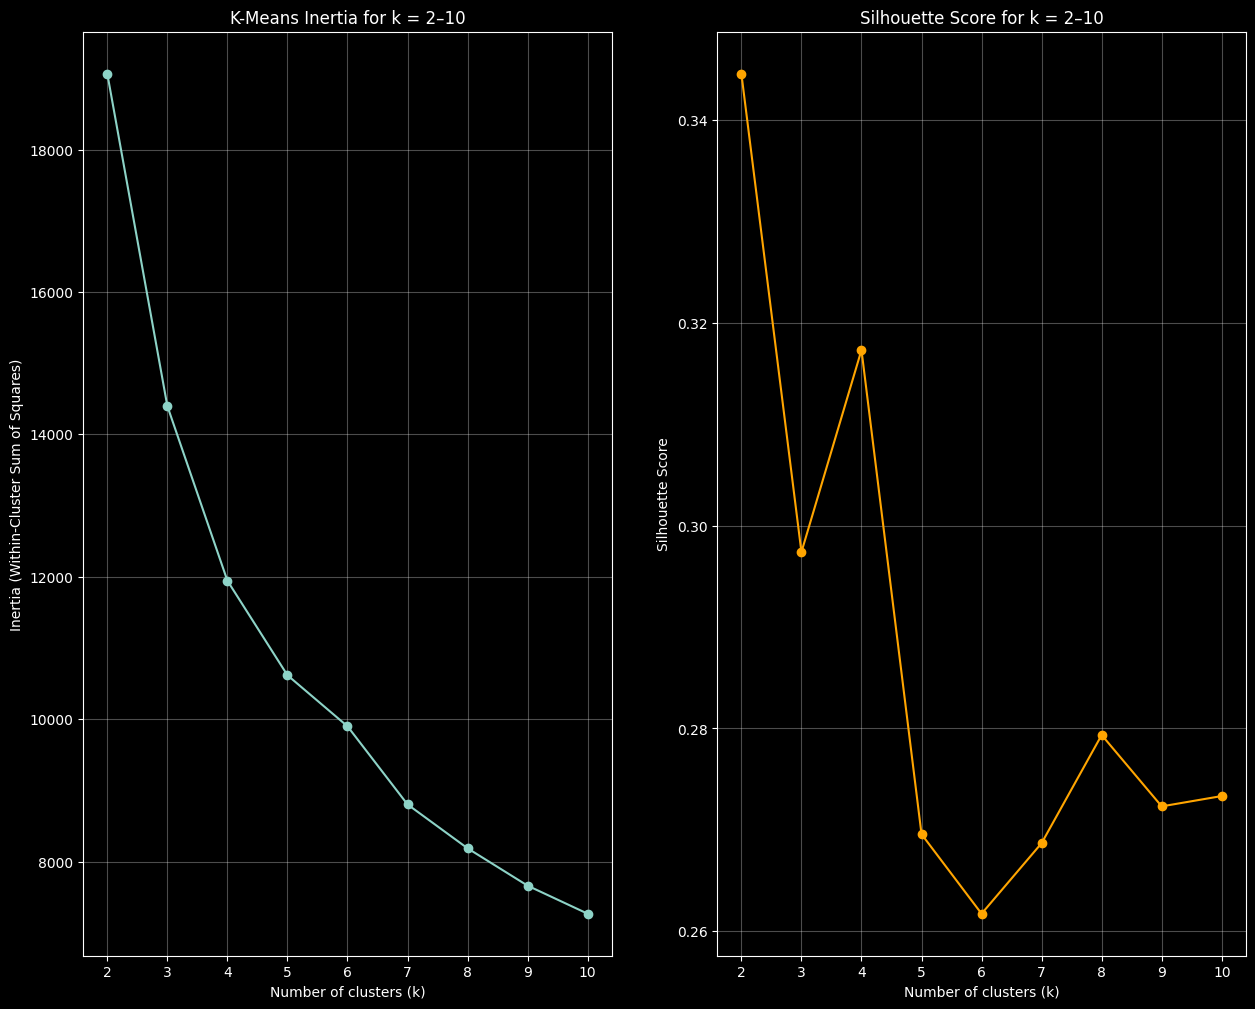

In [18]:
inertias = []
silhouettes = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

fig, axes = plt.subplots(1, 2, figsize=(15, 12))

axes[0].plot(range(2, 11), inertias, marker='o')
axes[0].set_title("K-Means Inertia for k = 2–10")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia (Within-Cluster Sum of Squares)")
axes[0].grid(alpha=0.3)

axes[1].plot(range(2, 11), silhouettes, marker='o', color='orange')
axes[1].set_title("Silhouette Score for k = 2–10")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].grid(alpha=0.3)

ks = range(2, 11)

for k, score in zip(ks, silhouettes):
    print(f"{k}: {score}")

The elbow occurs at k=4. The max silhouette score also occurs at k=4. This is the same number of clusters suggested by hierarchical clustering using the Ward method.

## Final cluster selection
We will select 4 clusters for the final customer segmentation, as suggested by both the elbow method and silhouette scores, and supported by the dendrogram structure. This number of clusters balances the need for actionable insights with the risk of overgeneralization, allowing us to effectively target distinct customer segments.

## Final K-means model

In [19]:
# Final K-means model with 4 clusters
kmeans_final = KMeans(n_clusters=4, n_init='auto', random_state=42)
kmeans_final.fit(X_scaled)

# Print cluster sizes and percentages
print("Cluster Distribution:")
print("=" * 40)
print(df['cluster_4'].value_counts().sort_index())
print("\nCluster Percentages:")
print("=" * 40)
print((df['cluster_4'].value_counts(normalize=True).sort_index() * 100).round(2))

Cluster Distribution:
cluster_4
1     540
2     959
3     420
4    1081
Name: count, dtype: int64

Cluster Percentages:
cluster_4
1    18.00
2    31.97
3    14.00
4    36.03
Name: proportion, dtype: float64


## Cluster visualization

Explained variance by component:
[0.41005535 0.20971696]


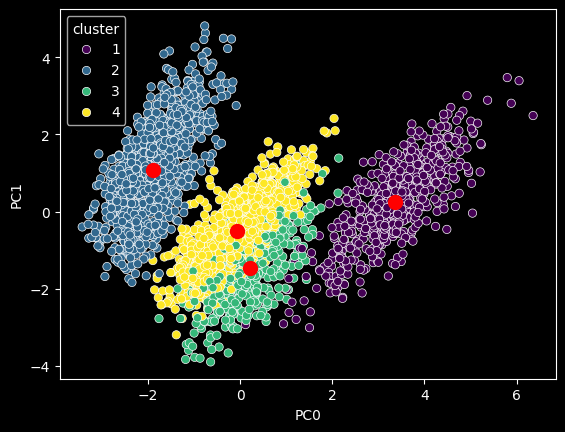

In [63]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

print("Explained variance by component:")
print(pca.explained_variance_ratio_)

PC0 = pca.components_[0]
PC1 = pca.components_[1]

df_pca = pd.DataFrame(
    X_2D,
    columns=["PC0", "PC1"]
)

df_pca["cluster"] = df["cluster_4"]

centroids = df_pca.groupby("cluster").mean()
plt.figure()
sns.scatterplot(data=df_pca, x="PC0", y="PC1", hue=df_pca['cluster'], palette='viridis')
plt.scatter(centroids.PC0, centroids.PC1, marker='o', color='r', s=100)

Above, we can see a plot of the projection of the 9 variables describing our customers into two dimentions. This is useful for cluster visualization but actual clusters exist in 9-dimentional space (see pairplot above). We note that these two dimentions only capture ~62% of the variance in customer data.

## Technical Conclusion

In [64]:
# Key characteristics of each discovered segment:
print("Key characteristics of each discovered segment:")
for cluster in sorted(df['cluster_4'].unique()):
    segment = df[df['cluster_4'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f" - Number of customers: {len(segment)}")
    print(f" - Average Total Spend: ${segment['total_spend'].mean():.2f}")
    print(f" - Average Monthly Transactions: {segment['monthly_transactions'].mean():.2f}")
    print(f" - Average Return Rate: {segment['return_rate'].mean():.2%}")
    print(f" - Average Product Views per Visit: {segment['product_views_per_visit'].mean():.2f}")
    print(f" - Average Recency (days): {segment['recency_days'].mean():.2f}")

Key characteristics of each discovered segment:

Cluster 1:
 - Number of customers: 540
 - Average Total Spend: $6518.33
 - Average Monthly Transactions: 13.96
 - Average Return Rate: 10.73%
 - Average Product Views per Visit: 42.35
 - Average Recency (days): 7.88

Cluster 2:
 - Number of customers: 959
 - Average Total Spend: $417.18
 - Average Monthly Transactions: 1.63
 - Average Return Rate: 26.63%
 - Average Product Views per Visit: 29.78
 - Average Recency (days): 35.22

Cluster 3:
 - Number of customers: 420
 - Average Total Spend: $3791.28
 - Average Monthly Transactions: 3.76
 - Average Return Rate: 23.91%
 - Average Product Views per Visit: 16.27
 - Average Recency (days): 20.33

Cluster 4:
 - Number of customers: 1081
 - Average Total Spend: $1470.69
 - Average Monthly Transactions: 6.80
 - Average Return Rate: 13.31%
 - Average Product Views per Visit: 33.13
 - Average Recency (days): 14.31


Main technical insights:
Both hierarchical and K-means clustering suggest 4 clusters as optimal.
The silhouette score for the final K-means model with 4 clusters is 0.316, indicating moderate cluster separation.
Hierarchical clustering with Ward linkage produced compact clusters, while K-means provided similar results with faster computation.
Each cluster exhibits distinct characteristics in terms of spending behavior, return rates, and engagement metrics, which can inform targeted marketing strategies. Some variables show strong cluster separation, as seen in the pairplot visualizations.

Key characteristics of each discovered segment:

Cluster 1: High-Value Loyal Customers
 - High total spend and frequent transactions
 - Low return rates and high engagement
 - Recent activity indicating strong loyalty

Cluster 2: Low-Value Occasional Shoppers
 - Low total spend and infrequent transactions
 - High return rates and low engagement
 - Less recent activity suggesting lower loyalty
 
Cluster 3: Mid-Value Cautious Buyers
 - Moderate total spend and transaction frequency
 - Higher return rates indicating cautious purchasing behavior
 - Moderate engagement and recency

Cluster 4: Mid-Value Engaged Customers
 - Moderate total spend with higher transaction frequency
 - Moderate return rates and high engagement
 - Recent activity indicating good loyalty